In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.optimize as sop
import warnings
warnings.filterwarnings('ignore')

mosprime3m = pd.read_csv('mosprime3m.csv',header=None,
                         index_col=0, names=['r3m'])['r3m']
mosprime3m_between = pd.read_csv('mosprime3m_between.csv', header=None,
                                 index_col=0, names=['r3m'])['r3m']
mosprime3m_short = pd.read_csv('mosprime3m_short.csv', header=None,
                               index_col=0, names=['r3m'])['r3m']

def merton_path(r0, days, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    a = a # альфа 
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = r[t - 1] +  a*dt + vol * rand[t] * np.sqrt(dt)
    merton = pd.DataFrame(r[:, 0], columns=['index'])
    merton = merton.values.flatten()
    return merton

def m_p(data, opt, num_paths=10, alpha=0.7, title='Calibrated Merton Short Rate Simulation'):
    for i in range(num_paths):
        plt.plot(merton_path(data[0], len(data), opt[0], opt[1]),
                 lw=0.8, alpha=0.7)
    plt.title(title)
    plt.plot(data.values.flatten(), label = 'data')
    plt.legend()
    plt.tight_layout
    plt.show()

In [2]:
data = mosprime3m_short

In [92]:
p0 = np.array([ 0.45,  0.4 ])

In [93]:
def merton_ml_diff(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    dx = np.diff(data.values)
    t = (np.array(list(range(len(data)))) + 1)/252
    dt = np.array([1/252]*len(x))
    sigma = vol * np.sqrt(dt)
    mu =  a * dt
    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [94]:
 def merton_ml_len1(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    x = data[1:].values
    t = (np.array(list(range(len(data)))) + 1)/252
    dt = np.array([1/252]*len(x))
    sigma = vol * np.sqrt(dt)
    mu = data[:-1].values + a * dt
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [95]:
 def merton_ml(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    sigma = vol * np.sqrt(t)
    mu = min(data) + a * t
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [113]:
 def merton_ml_last40(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    x = x[-40:]
    t = t[-40:]
    sigma = vol * np.sqrt(t)
    mu = min(data) + a * t
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [140]:
def merton_ml_random40(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    subset_ids = np.sort(np.random.permutation(data.shape[0])[:40])
    x = data[subset_ids].values
    t = (np.array(list(range(len(data)))) + 1)/252
    t = t[subset_ids]
    sigma = vol * np.sqrt(t)
    mu = min(data) + a * t
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

Optimization terminated successfully.
         Current function value: -205.020651
         Iterations: 45
         Function evaluations: 87
[ 1.017719    0.53495622]


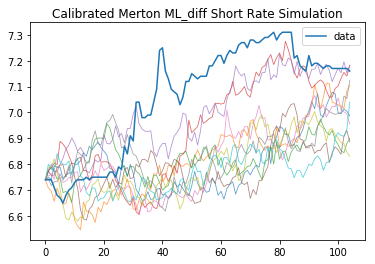

In [96]:
opt_ML1 = sop.fmin(merton_ml_diff, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

print(opt_ML1)

m_p(data, opt_ML1, num_paths=10, title='Calibrated Merton ML_diff Short Rate Simulation')

Optimization terminated successfully.
         Current function value: -205.020651
         Iterations: 45
         Function evaluations: 87
[ 1.017719    0.53495622]


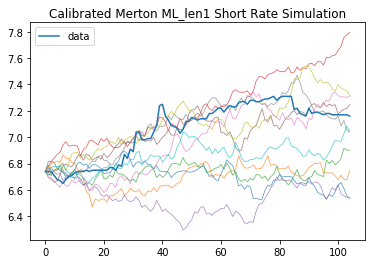

In [97]:
opt_ML2 = sop.fmin(merton_ml_len1, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

print(opt_ML2)

m_p(data, opt_ML2, num_paths=10, title='Calibrated Merton ML_len1 Short Rate Simulation')

Optimization terminated successfully.
         Current function value: -78.440199
         Iterations: 45
         Function evaluations: 85
[ 1.92814267  0.28830034]


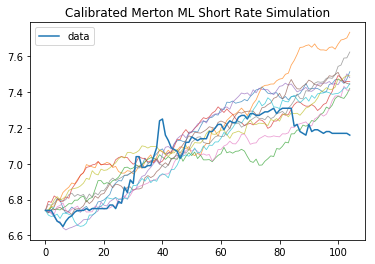

In [98]:
opt_ML3 = sop.fmin(merton_ml, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

print(opt_ML3)

m_p(data, opt_ML3, num_paths=10, title='Calibrated Merton ML Short Rate Simulation')

Optimization terminated successfully.
         Current function value: -26.207512
         Iterations: 46
         Function evaluations: 87
[ 1.71536928  0.21677507]


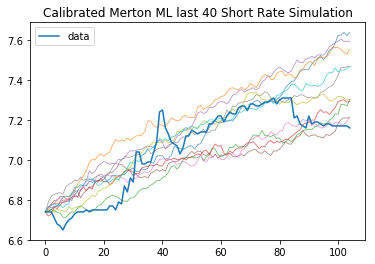

In [121]:
opt_ML4 = sop.fmin(merton_ml_last40, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

print(opt_ML4)

m_p(data, opt_ML4, num_paths=10, title='Calibrated Merton ML last 40 Short Rate Simulation')

[ 0.48375  0.495  ]


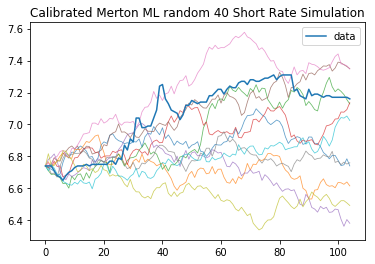

In [141]:
opt_ML5 = sop.fmin(merton_ml_random40, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

print(opt_ML5)

m_p(data, opt_ML5, num_paths=10, title='Calibrated Merton ML random 40 Short Rate Simulation')